# Introduction

In this work, we will consider the application of likelihood-free inference in state space models. State space models describes a dynamical system which has a certain state $x_t$ at time $t$. For example, a falling ball can be described with a state space model with $x_t$ descibing the height of the ball at time $t$. We assume that the state space model is discretized, such that $t$ take integer values. The state can evolve stochastically, so we define a **process model** which takes the form $X_t|X_{t-1} \sim p(x_{t}|x_{t-1}, \psi)$. The vector $\psi$ parametrizes the probability distribution that governs how the state will evolve. Furthermore, we assume that the true state of the system $x_t$ is not completely accessible to us. Thus, we have to measure it at each time $t$, leading to a **measurement model** $Y_t|X_t \sim p(y_{t}|x_{t}, \phi)$. We make the following assumptions to make our lives easier:
* Markov Property: The current state is conditionally independent to all past states given the immediately previous state: $p(x_{t}|x_{1:t}, \psi) =p(x_t|x_{t-1},  \psi)$
* Conditional independence of measurement: The measurements are conditionally independent from each other and depend only on the current state.

These are the likelihoods functions that make up the model, which can be described with the following graphical model. ![image.png](graph.png)



This model has an intractable likelihood $p(y_{1:T}|\theta)$ where $\theta = (\psi, \phi)$, ignoring the latent states. Thus, the measurements $y_{1:T}$ are not independent from one another and we cannot use iid updates like with most data sets. To see why, note that $$p(y_{1:T}|\theta) =\int p(y_{1:T}, x_{0:T}|\theta) dx_{0:T}= \int p(y_{1:T}|x_{0:T}, \theta) p(x_{0:T}|\theta)dx_{0:T} \\
= \int \prod_{t=1}^T p(y_t|x_t, \theta) \left[p(x_{0}|\theta) \prod_{t=1}^T p(x_t|x_{t-1}, \theta) \right]dx_{0:T} $$

Because in general we don't know the form of the transition probabilities $p(x_t|x_{t-1})$, this likelihood is intractable. Therefore, we will use the mechanism of ABC-MCMC to help us solve the inference problem. This problem has important applications, since state space models can be used to model dynamical processes. The problem of inferring the underlying behavior of a system given only observations (which can be noisy) is a general problem of science. 

## Importing Packages

In [195]:
# library and dataset
from matplotlib import pyplot as plt
%matplotlib inline
from IPython.display import HTML

import pandas as pd
import numpy as np

## Demonstrating ABC-MCMC on a Simple 2D Dynamical System with No Measurement Noise

We assume that the initial location of the particle is known to be (1, 1). Furthermore, we assume that there is no measurement noise. That is, we know the latent state of the system. The system's state is a 2D vector that describes its position on a plane. Then, the system's state evolves according to $$\begin{bmatrix}x_t \\y_t \end{bmatrix} = \begin{bmatrix}0.97 & -0.25 \\0.8& 0.8 \end{bmatrix} \begin{bmatrix}x_{t-1} \\y_{t-1} \end{bmatrix} $$

From this, we generate some "real data."

The problem of inference is then to infer the parameters of the matrix. We assume that the parameters come from a jointly independent prior univariate standard Gaussian. In the plot below, we show the trajectory of the dynamical system and the plot of the final trajectory.

[1 1]
[0.72 1.6 ]
[0.2984 1.856 ]
[-0.174552  1.72352 ]
[-0.60019544  1.2391744 ]
[-0.89198318  0.51118317]
[-0.99301947 -0.30464001]
[-0.88706889 -1.03812758]
[-0.60092492 -1.54015718]
[-0.19785788 -1.71286568]
[ 0.23629427 -1.52857885]
[ 0.61135016 -1.03382766]
[ 0.85146657 -0.337982  ]
[0.91041807 0.41078765]
[0.78040862 1.05696458]
[0.49275521 1.46989856]
[0.11049792 1.57012302]
[-0.28534777  1.34449675]
[-0.61291153  0.84731918]
[-0.80635398  0.18752612]
[-0.82904489 -0.49506229]
[-0.68040797 -1.05928574]
[-0.3951743  -1.39175497]
[-0.03538033 -1.42954341]
[ 0.32306694 -1.17193899]
[ 0.60635968 -0.67909764]
[ 0.7579433  -0.05819037]
[0.74975259 0.55980234]
[0.58730943 1.04764394]
[0.30777916 1.3079627 ]
[-0.02844489  1.29259349]
[-0.35073991  1.01131888]
[-0.59304744  0.52846317]
[-0.70737181 -0.05166741]
[-0.6732338  -0.60723138]
[-0.50122894 -1.02437214]
[-0.23009904 -1.22048086]
[ 0.08192415 -1.16046392]
[ 0.36958241 -0.86283182]
[ 0.57420289 -0.39459953]
[0.65562668 0.14368269

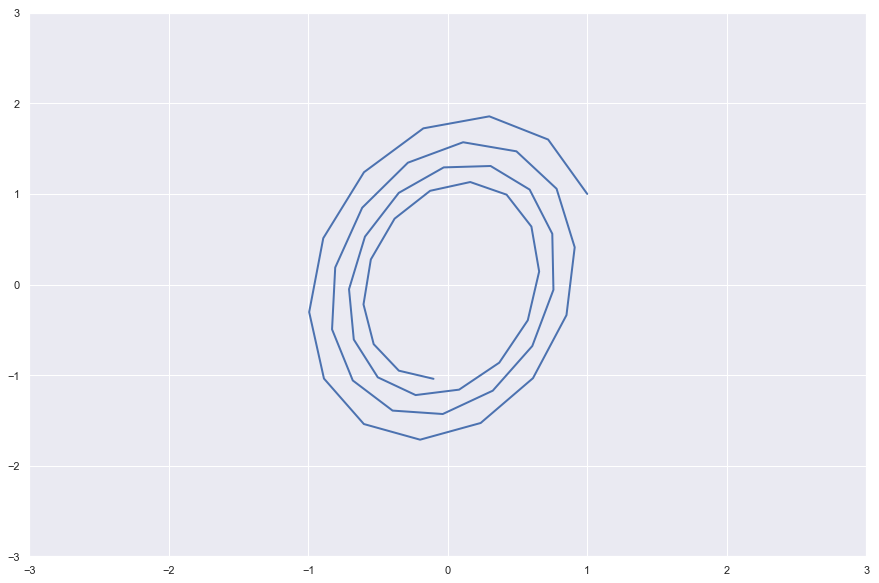

In [198]:
from matplotlib import animation

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure(figsize=(15,10))
ax = plt.axes(xlim=(-3, 3), ylim=(-3,3))
line, = ax.plot([], [], lw=2)


# initialization function: plot the background of each frame
def init():
    line.set_data([1], [1])
    return line,

# animation function.  This is called sequentially
def animate(i):
    x, y = line.get_data()
    state = np.array([x[-1], y[-1]])
    new_state = np.array([[0.97, -0.25], [0.8, 0.8]]).dot(state) 
    print(state)
    x.append(new_state[0])
    y.append(new_state[1])
    line.set_data(x, y)
    return line,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=50, interval=100, blit=True)

HTML(anim.to_html5_video())



To perform ABC, we sample each parameter by putting a univariate Gaussian of variance 0.5 centered at the current parameter and simulate a trajectory based on those parameters. We will use a Gaussian kernel to measure the distance between the real data and the simulated data. The biggest problem with performing this method is to choose the appropriate sufficient statistics, since the data trajectory of 50 points leads to a very quick decaying of probability if we multiply the Gaussian kernels for each individual point. The acceptance rate decays exponentially with the length of the trajectory, unless ε is increasing with T, leading to an unacceptable decrease in accuracy in the approximate posterior. My naive sufficient statistics to use is to multiply the probabilities of only the last 10 points of the trajectory. I reason that if the parameter is very wrong, the last 10 points of the simulated trajectory is unlikely to be close to that of the real trajectory. Hopefully this will provide parameter values that are similar to what we want.

Then, the ABC-MCMC sampler proposes a move from one state $(\theta_{old}, x_{old})$ to $(\theta_{new}, x_{new})$ using the following acceptance probability $$\frac{\pi_{\epsilon}(y|x_{new}, \theta_{new}) p(\theta_{new})}{\pi_{\epsilon}(y|x_{old}, \theta_{old}) p(\theta_{old})}$$ where $\pi_{\epsilon}(y|x_{new}, \theta_{new})$ is the Gaussian kernel measuring the distance between the real data $y$ and the simulated data $x_{new}$ or $x_{old}$. $p(\theta_{new})$ is the prior probability of the parameters, which is simply a product of unit variance Gaussians centered at 0 for the 4 parameters.

In [226]:
real_data

[(1, 1),
 (0.72, 1.6),
 (0.2983999999999999, 1.8560000000000003),
 (-0.1745520000000002, 1.7235200000000002),
 (-0.6001954400000002, 1.2391744),
 (-0.8919831768000003, 0.5111831679999999),
 (-0.9930194734960003, -0.3046400070400003),
 (-0.8870688875311202, -1.0381275844288005),
 (-0.6009249247979864, -1.5401571775679366),
 (-0.19785788266206272, -1.7128656818927386),
 (0.23629427429098382, -1.5285788516438412),
 (0.6113501589732147, -1.0338276618822861),
 (0.8514665696745898, -0.33798200232725717),
 (0.9104180731661664, 0.41078765387786614),
 (0.7804086175017149, 1.0569645816352262),
 (0.49275521356785684, 1.469898559309553),
 (0.11049791733343284, 1.5701230183019281),
 (-0.2853477747620522, 1.3444967485082888),
 (-0.6129115286462627, 0.8473191789969894),
 (-0.8063539775361221, 0.18752612028058135),
 (-0.8290448882801837, -0.4950622858044327),
 (-0.68040797018067, -1.059285739267693),
 (-0.3951742962583266, -1.3917549675586907),
 (-0.03538032548090414, -1.4295434110536138),
 (0.3230669

To improve the performance of the ABC-MCMC sampler, I used an error-augmented sampler, defining a prior distribution for the scale ε of the Gaussian kernel. The larger ε is, the greater the acceptance rate, which encourages the chains to mix. On the other hand, a small ε value encourages the data generated to be close to the real data. The error-augmented sampler simply decays the value of ε after every proposal. This use of the error-augmented sampler follows the idea of an auxiliary variable, lifting the sampler into an augmented probability space that improves its behavior.

In [341]:
# No sufficient statistics used
from scipy import stats

def lf_mcmc(dim, real_data, step_size = 0.9998, max_t = 10000, prior_hyperparams = [0, 0, 0, 0]):
    acceptance = 0
    chains = {"chain1": [], "chain2": [], "chain3": [], "chain4": []}
    for chain in chains:
        # initial data generation
        a, b, c, d = stats.multivariate_normal.rvs(mean=[0,0,0,0], cov = np.eye(dim))
        trajectory = [[1, 1]]
        for _ in range(50):
            trajectory.append(np.array([[a, b], [c, d]]).dot(trajectory[-1]))
        # distance kernel

        gaussian_dist = [(stats.multivariate_normal.pdf(trajectory[i], real_data[i], np.eye(2))) for i in range(len(trajectory) - 10, len(trajectory))]
        gaussian_dist = np.product(gaussian_dist)
        samples = [(a, b, c, d, gaussian_dist)]

        for _ in range(1, max_t):
            eps = max(0.1, step_size**max_t)
            # propose new parameter values
            a_, b_, c_, d_, gaussian_dist_ = samples[-1] # current values
            a, b, c, d = np.random.normal([a_, b_, c_, d_], 0.5)

            # generate new data
            trajectory = [[1, 1]]
            for _ in range(50):
                trajectory.append(np.array([[a, b], [c, d]]).dot(trajectory[-1]))

            gaussian_dist = [(stats.multivariate_normal.pdf(trajectory[i], real_data[i], eps*np.eye(2))) for i in range(len(trajectory) - 10, len(trajectory))]
            gaussian_dist = np.product(gaussian_dist)
    
            numerator = gaussian_dist * stats.multivariate_normal.pdf(prior_hyperparams, [a, b, c, d], np.eye(dim))  
            denom = gaussian_dist_ * stats.multivariate_normal.pdf(prior_hyperparams, [a_, b_, c_, d_], np.eye(dim)) + 1e-30
    
            # accept or reject state
            if np.random.random() < min(1, numerator/denom):
                acceptance += 1
                samples.append([a, b, c, d, gaussian_dist])
            else:
                samples.append([a_, b_, c_, d_, gaussian_dist_])
        chains[chain] = samples
        
    return chains, acceptance








In [342]:
chains, acceptance = lf_mcmc(4, real_data)
samples = []
for chain in chains:
    samples.extend(chains[chain])
    

51
51
51
51


I plot histograms for samples from the posterior of each parameter. To help get independent samples from the posterior, I discard the first 4000 samples and use thinning, taking only every 10 states at a time. We can see that the posteriors have peaks at the true value of the parameters. However, it is clear that the posterior distribution is multimodal, especially due to interaction effects between the parameters. The determinant of the matrix has special significance here, since it represents the volume of a unit square after transformation by the matrix. If the determinant of the matrix $ab - cd$ is less than 1, then the linear transformation eventually maps the state to 0, whereas if the determinant of the matrix is greater than 1, then the state evolution diverges. Therefore, we see significance correlations in the triangle correlation plot. Furthermore, this could be evidence that the MCMC sampler has trouble, since MCMC has trouble traveling across modes. 

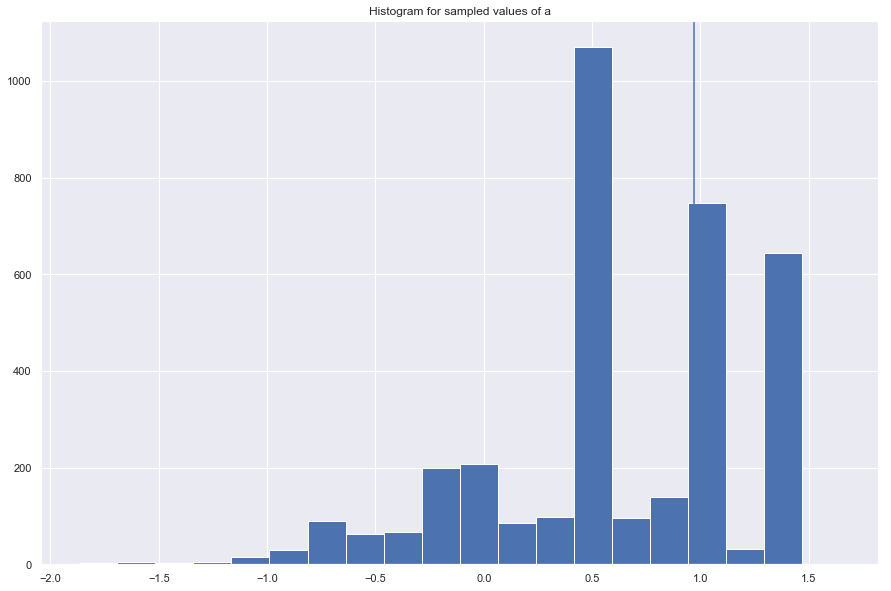

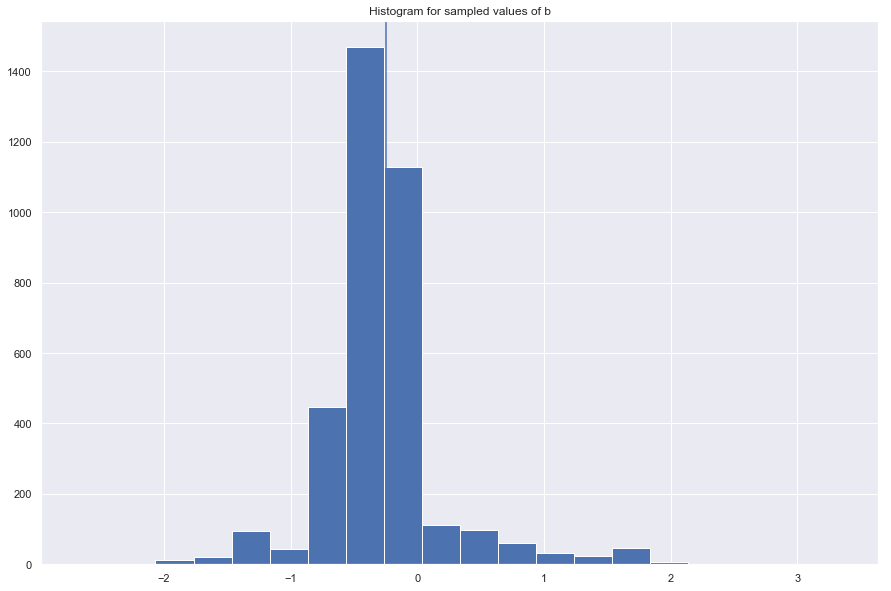

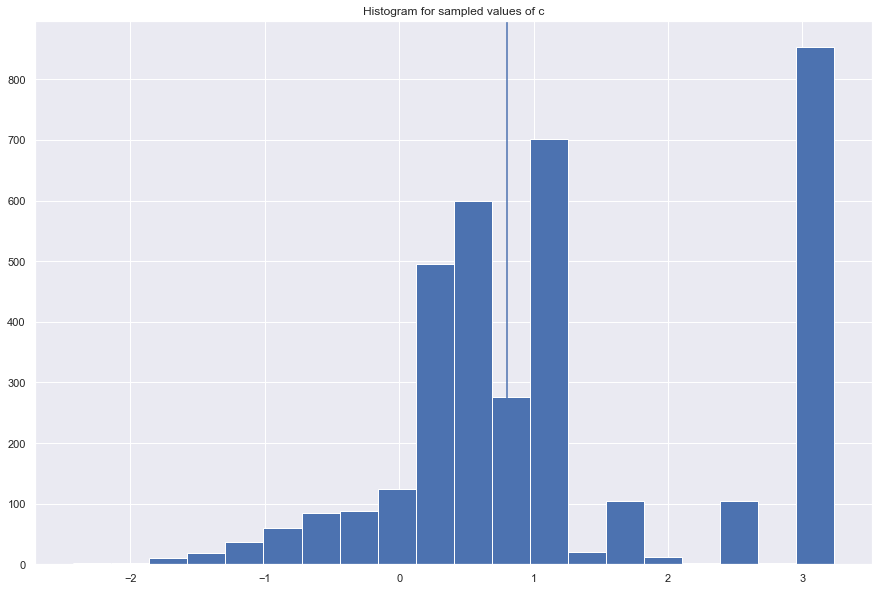

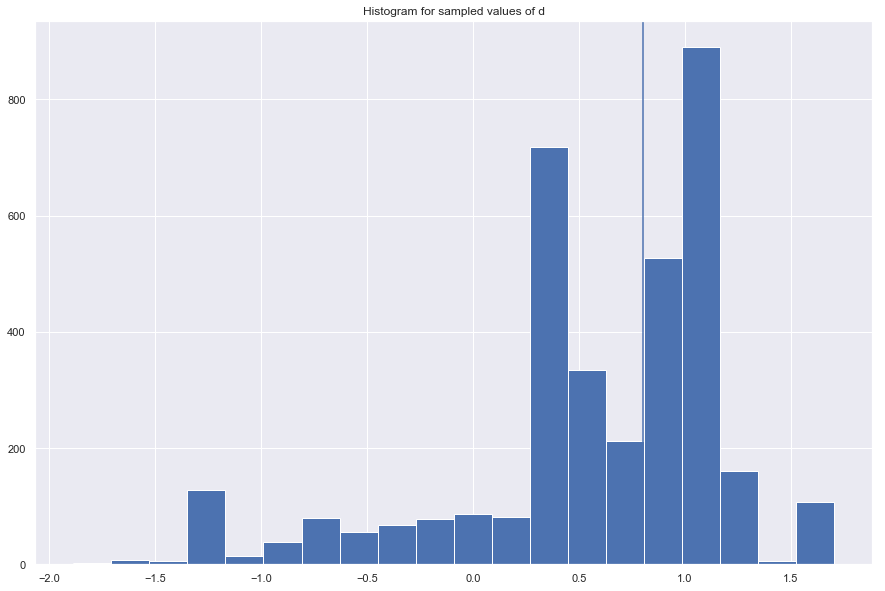

In [358]:
a, b, c, d, e = zip(*samples)

plt.figure(figsize=(15,10))
plt.hist(a[4000::10], 20)
plt.title("Histogram for sampled values of a")
plt.axvline(0.97) # true value of a
plt.show()
plt.figure(figsize=(15,10))
plt.hist(b[4000::10], 20)
plt.title("Histogram for sampled values of b")
plt.axvline(-0.25) # true value of b
plt.show()
plt.figure(figsize=(15,10))
plt.hist(c[4000::10], 20)
plt.title("Histogram for sampled values of c")
plt.axvline(0.8) # true value of c
plt.show()
plt.figure(figsize=(15,10))
plt.hist(d[4000::10], 20)
plt.title("Histogram for sampled values of d")
plt.axvline(0.8) # true value of d
plt.show()

I determine the 95% confidence interval based on the posterior samples

In [359]:
print("The 95% confidence interval for a is", np.percentile(a, [2.5, 97.5]))
print("The 95% confidence interval for b is", np.percentile(b, [2.5, 97.5]))
print("The 95% confidence interval for c is", np.percentile(c, [2.5, 97.5]))
print("The 95% confidence interval for d is", np.percentile(d, [2.5, 97.5]))

The 95% confidence interval for a is [-0.74655394  1.34174212]
The 95% confidence interval for b is [-1.42833746  1.06601667]
The 95% confidence interval for c is [-0.8483026  3.2370408]
The 95% confidence interval for d is [-1.22553379  1.55578015]


The pair plot shows that the marginal distribution of parameters might not tell us all the information we need, since there is significant correlation between the parameters, especially between $b$ and $c$, which makes sense, since they determine the sign of the determinant and the stability of the state evolution.

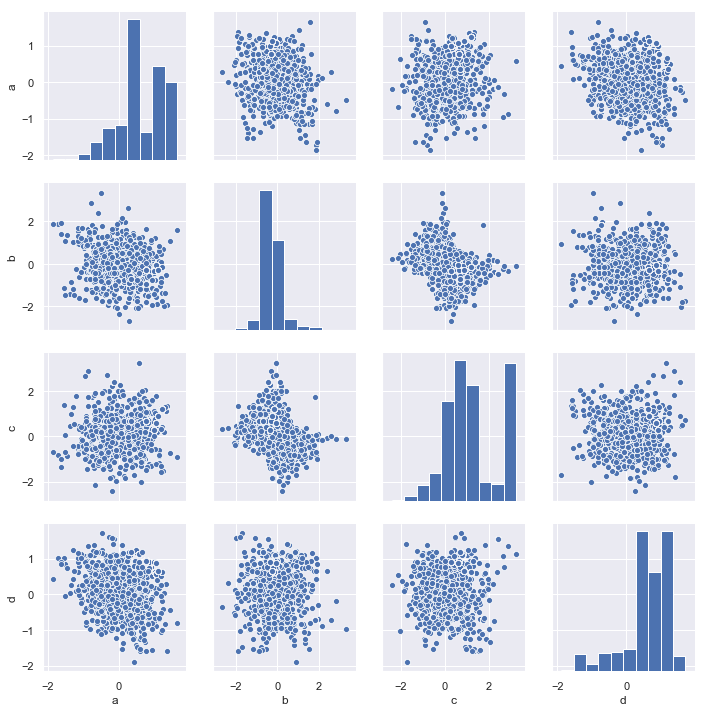

In [361]:
import pandas as pd
df = pd.DataFrame(data=np.transpose([a[4000::10],b[4000::10],c[4000::10],d[4000::10]]), columns=['a','b','c','d'])
sns.pairplot(df)

We plot some sample trajectories determined by the parameters from the posterior along with the real trajectory. While not absolutely perfect, this is a good approximation taking into account the sensitivity of the determinant to all values of $a$, $b$, $c$, $d$, and that the determinant landing on the correct side or wrong side of 1 can lead to diverging or converging behavior.

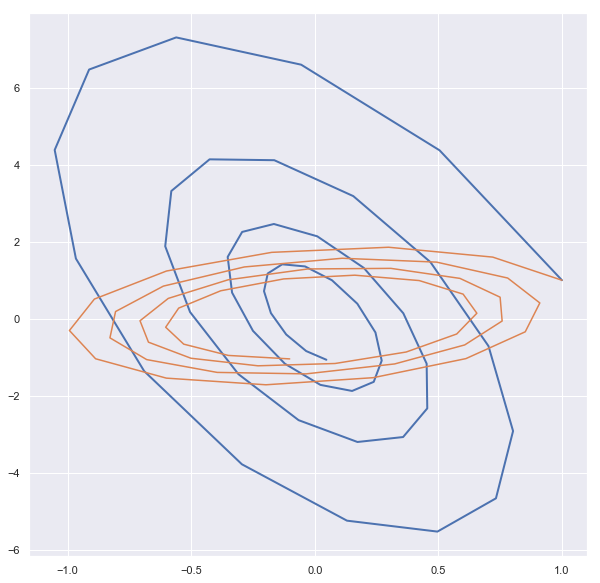

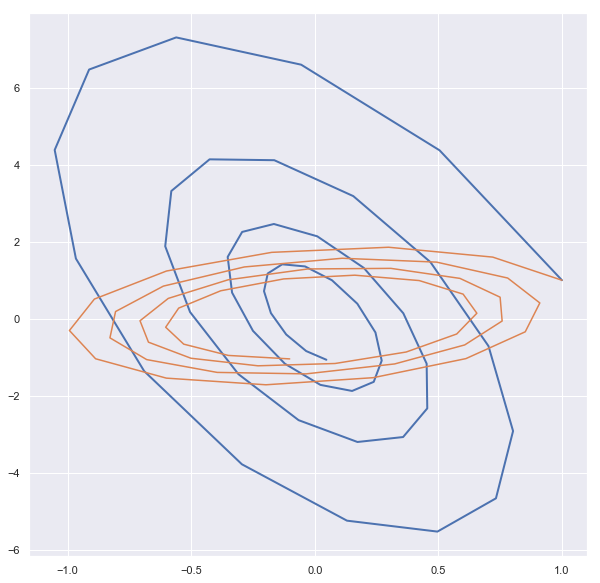

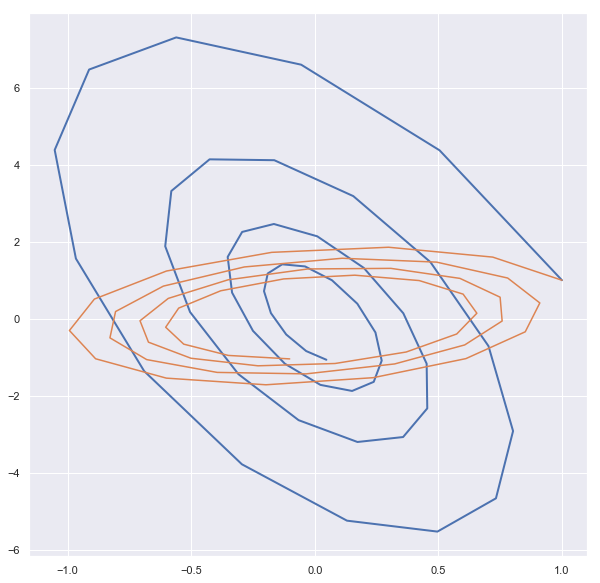

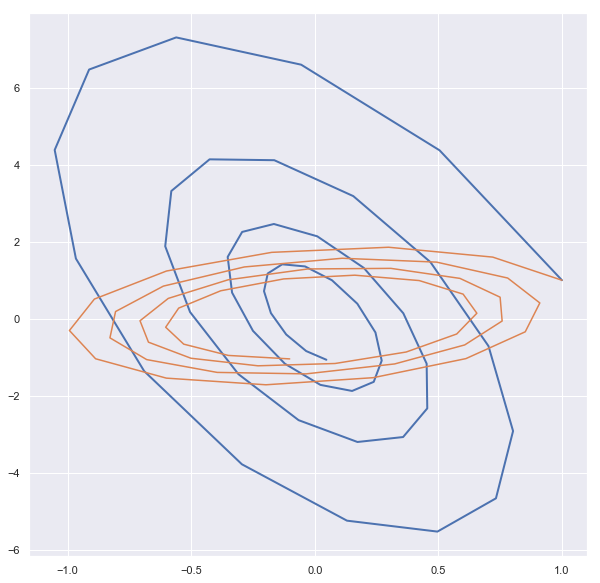

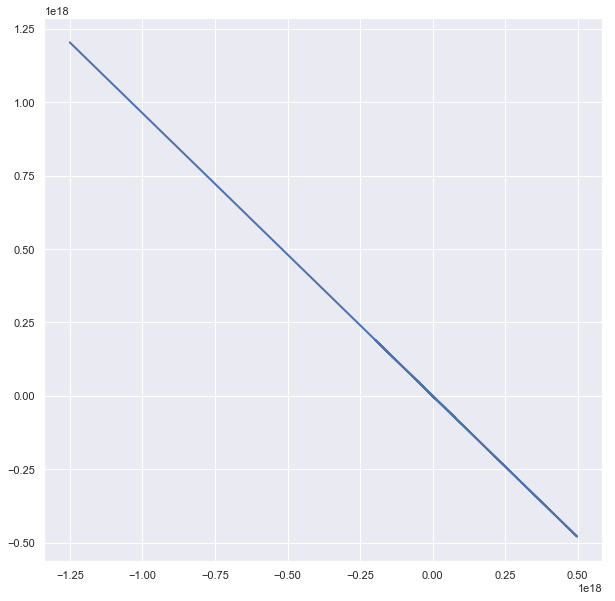

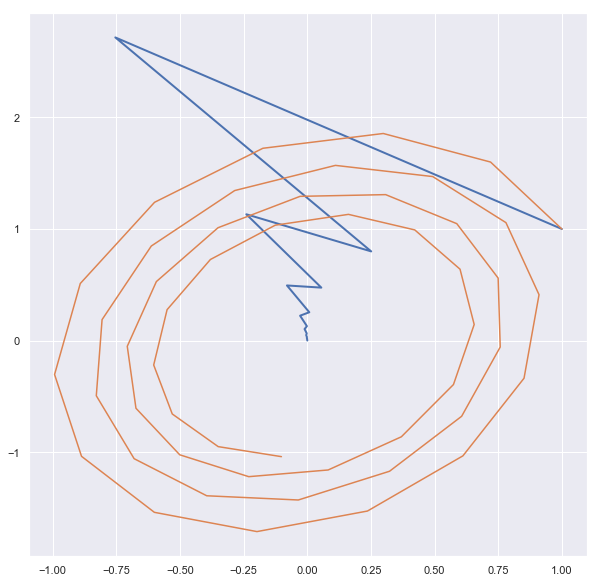

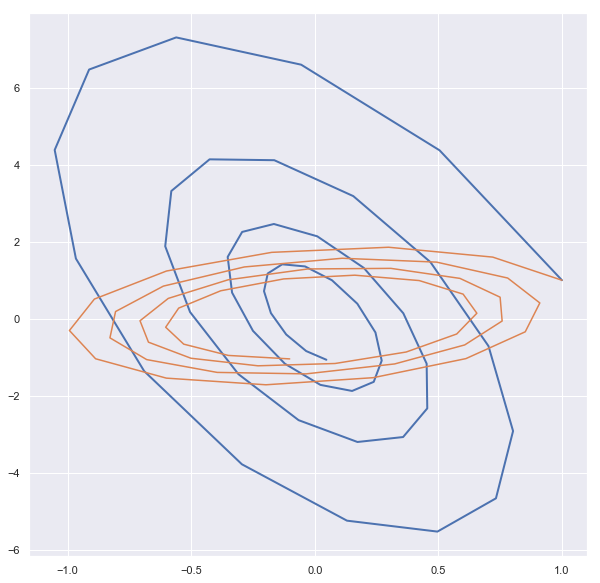

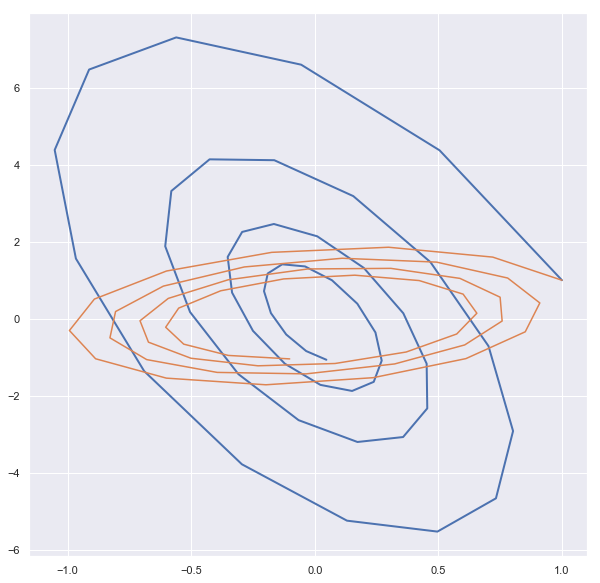

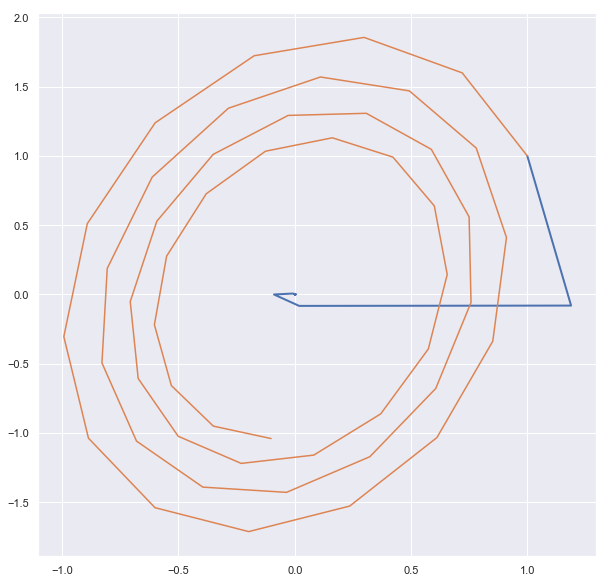

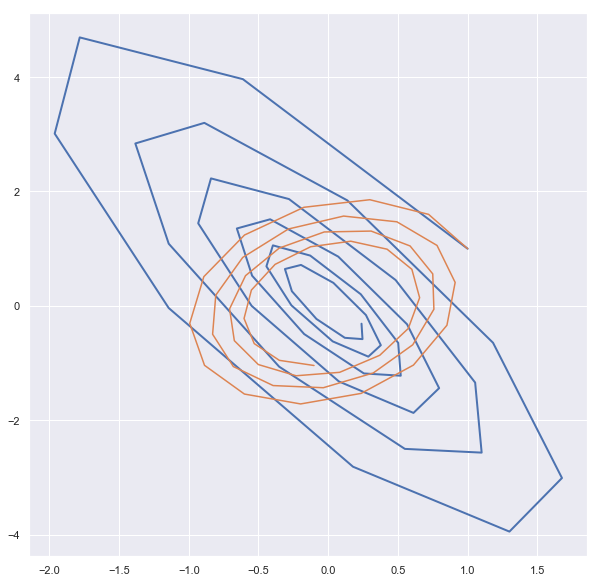

In [355]:
choice = np.random.randint(20000, 40000, 10)
for _ in choice:
    trajectory = [[1, 1]]
    for t in range(50):
        trajectory.append(np.array([[a[_], b[_]], [c[_], d[_]]]).dot(trajectory[-1]))
    x, y = zip(*trajectory)
    plt.figure(figsize=(10,10))
    plt.plot(x, y, lw=2)
    x, y = zip(*real_data)
    plt.plot(x, y)
    plt.show()

As an experiment, I did not change the step size of the error and kept it at 0.1. 

In [587]:
# No sufficient statistics used
from scipy import stats

def lf_mcmc(dim, real_data, step_size = 0.1, max_t = 10000, prior_hyperparams = [0, 0, 0, 0]):
    acceptance = 0
    acceptance_cum = [0]
    chains = {"chain1": [], "chain2": [], "chain3": [], "chain4": []}
    for chain in chains:
        # initial data generation
        a, b, c, d = stats.multivariate_normal.rvs(mean=[0,0,0,0], cov = np.eye(dim))
        trajectory = [[1, 1]]
        for _ in range(50):
            trajectory.append(np.array([[a, b], [c, d]]).dot(trajectory[-1]))
        # distance kernel
        gaussian_dist = [(stats.multivariate_normal.pdf(trajectory[i], real_data[i], np.eye(2))) for i in range(len(trajectory) - 10, len(trajectory))]
        gaussian_dist = np.product(gaussian_dist)
        samples = [(a, b, c, d, gaussian_dist)]

        for _ in range(1, max_t):
            eps = step_size
            
            # propose new parameter values
            a_, b_, c_, d_, gaussian_dist_ = samples[-1] # current values
            a, b, c, d = np.random.normal([a_, b_, c_, d_], 0.5)

            # generate new data
            trajectory = [[1, 1]]
            for _ in range(50):
                trajectory.append(np.array([[a, b], [c, d]]).dot(trajectory[-1]))

            # distance kernel
            gaussian_dist = [(stats.multivariate_normal.pdf(trajectory[i], real_data[i], eps*np.eye(2))) for i in range(len(trajectory) - 10, len(trajectory))]
            gaussian_dist = np.product(gaussian_dist)
            
            numerator = gaussian_dist * stats.multivariate_normal.pdf(prior_hyperparams, [a, b, c, d], np.eye(dim))  
            denom = gaussian_dist_ * stats.multivariate_normal.pdf(prior_hyperparams, [a_, b_, c_, d_], np.eye(dim)) + 1e-30

            # accept or reject state
            if np.random.random() < min(1, numerator/denom):
                acceptance += 1
                samples.append([a, b, c, d, gaussian_dist])
            else:
                samples.append([a_, b_, c_, d_, gaussian_dist_])
            acceptance_cum.append(acceptance)
        chains[chain] = samples
        
    return chains, acceptance_cum





We can see that the approximate posterior in this case looks similar with the above, but the small acceptance rate enforces that the generated trajectories in the last plot look more similar to the real data. Furthermore, we can see that the posterior 95% confidence is much smaller, since we have a small ε kernel from the beginning.

I also plot the cumulative distribution of acceptance probability. 

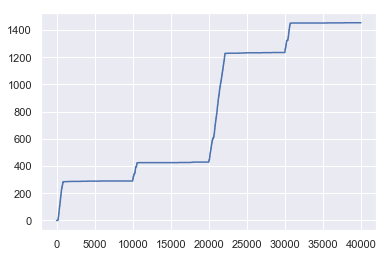

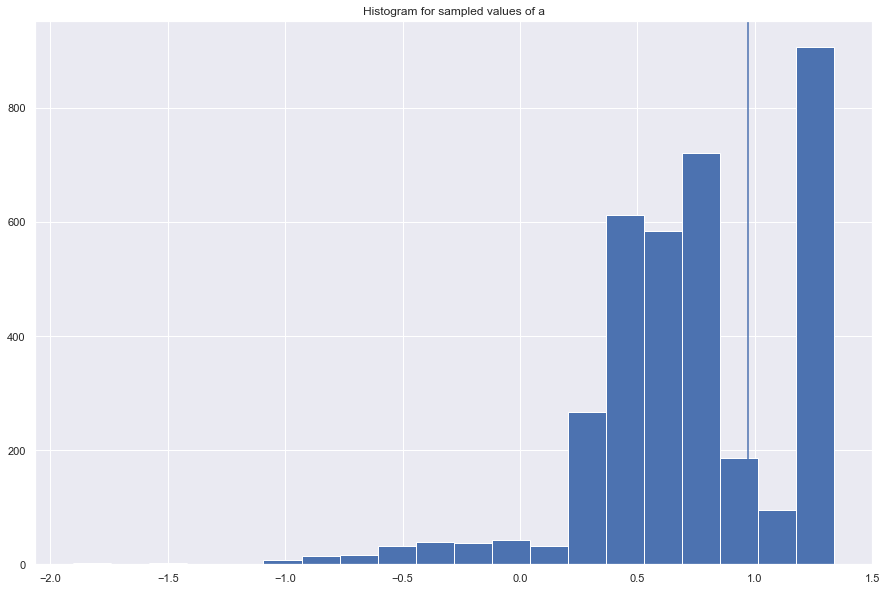

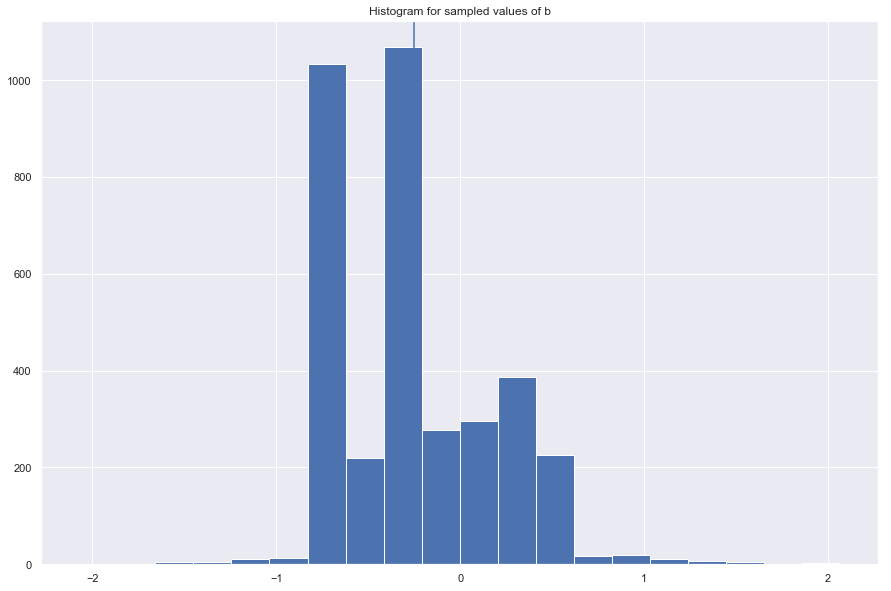

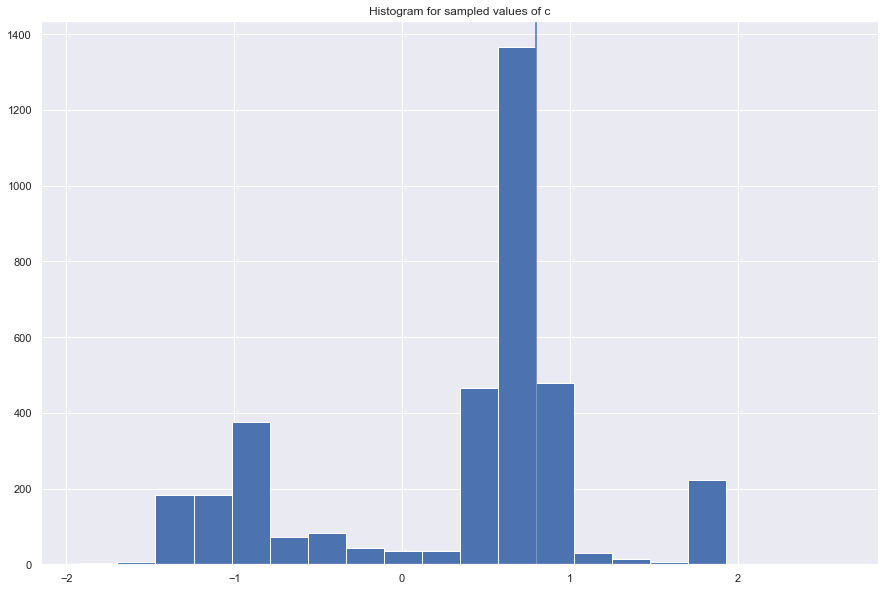

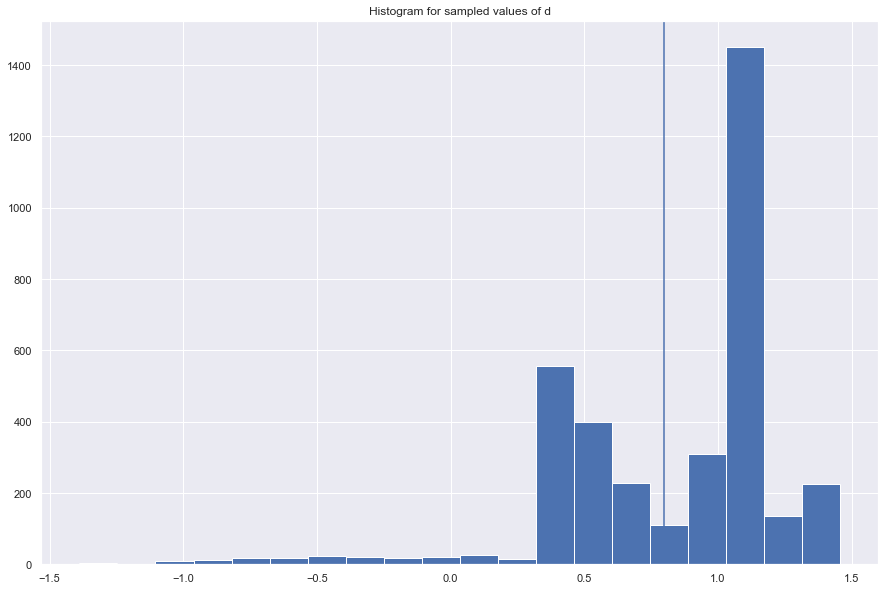

The 95% confidence interval for a is [-0.41095773  1.24026753]
The 95% confidence interval for b is [-0.67897315  0.56014864]
The 95% confidence interval for c is [-1.29519166  1.71158251]
The 95% confidence interval for d is [-0.4668394   1.34966875]


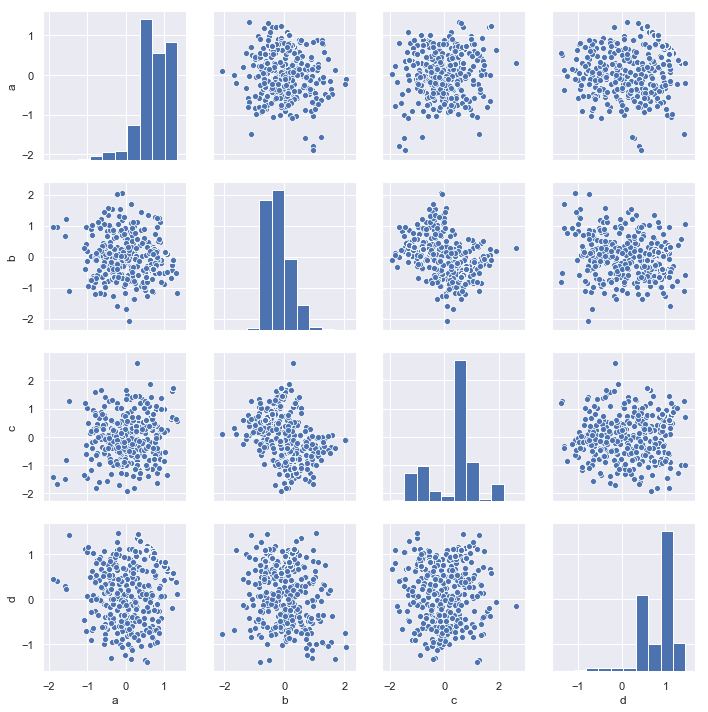

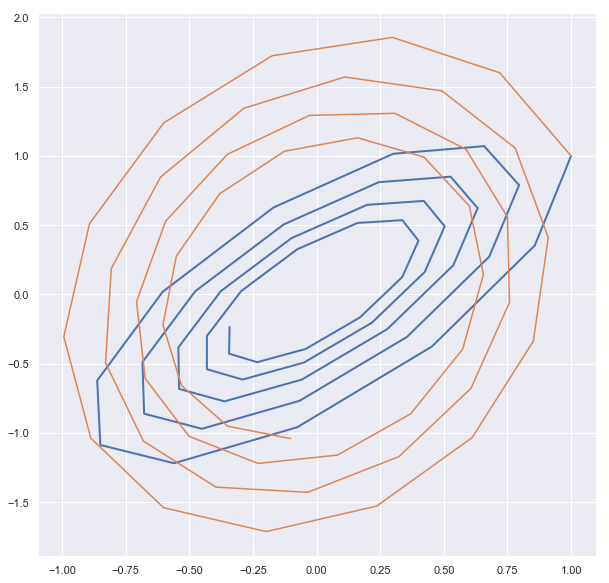

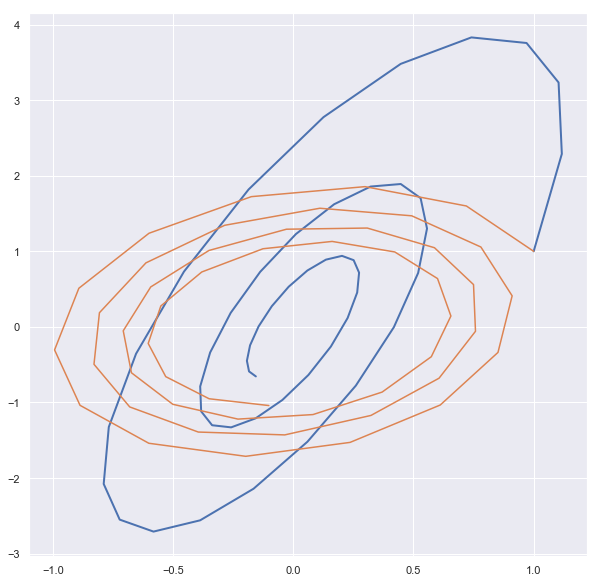

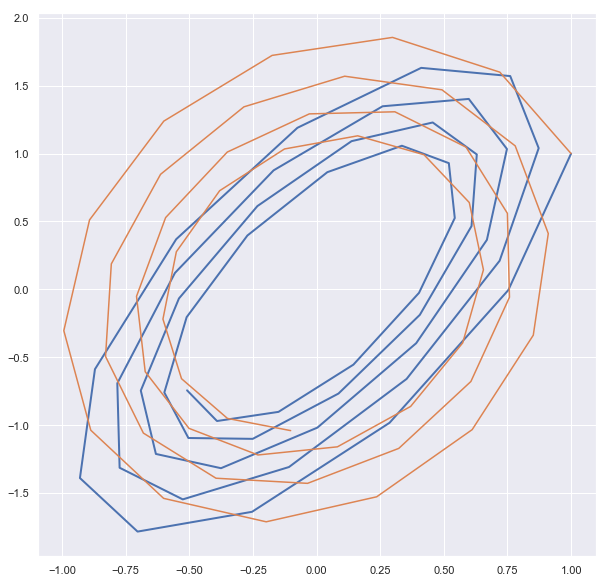

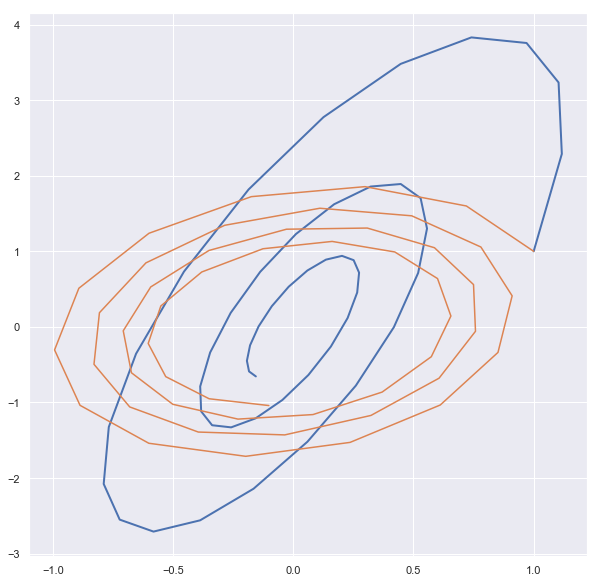

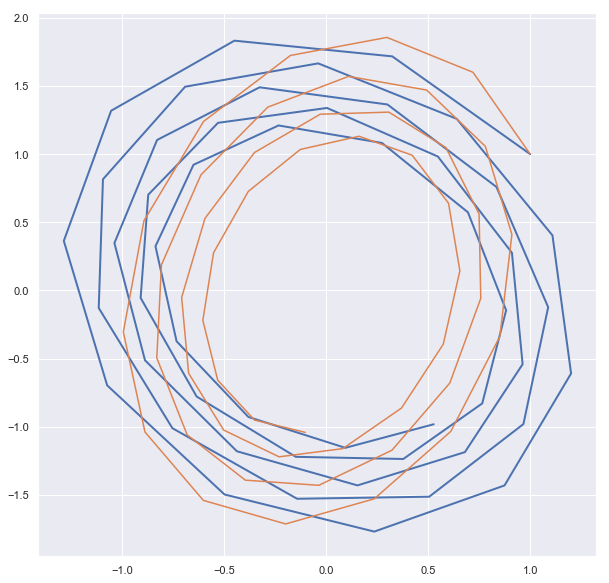

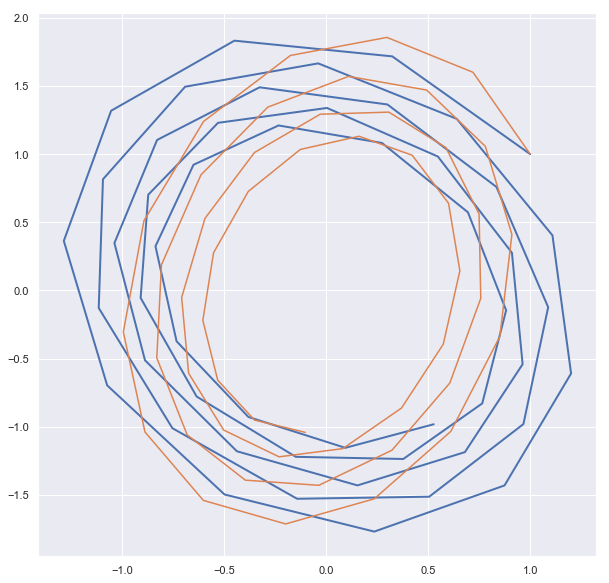

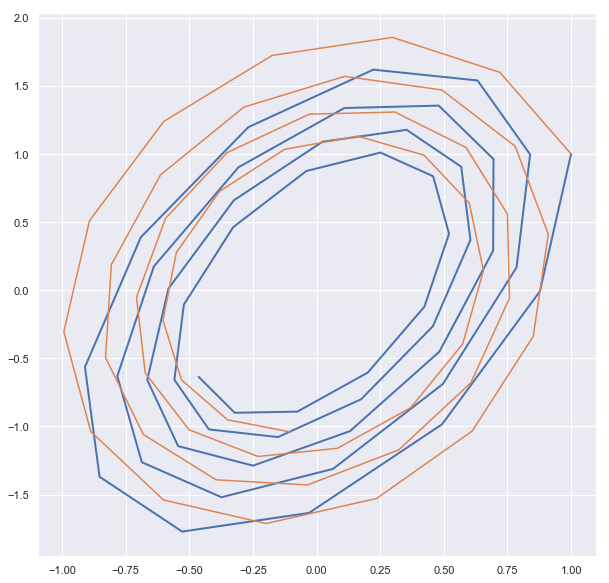

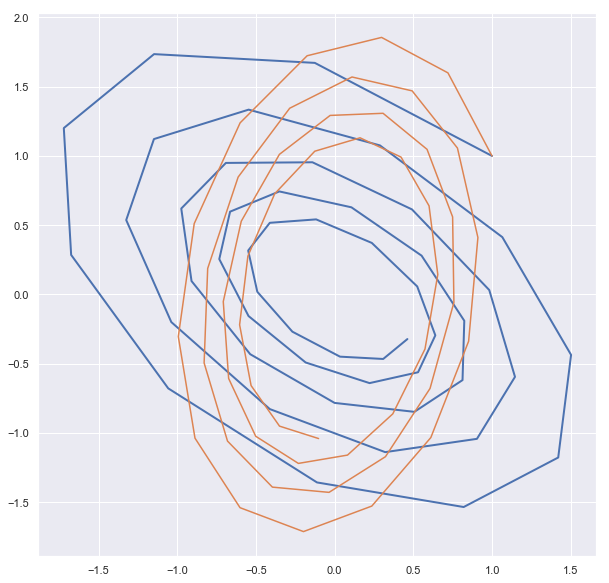

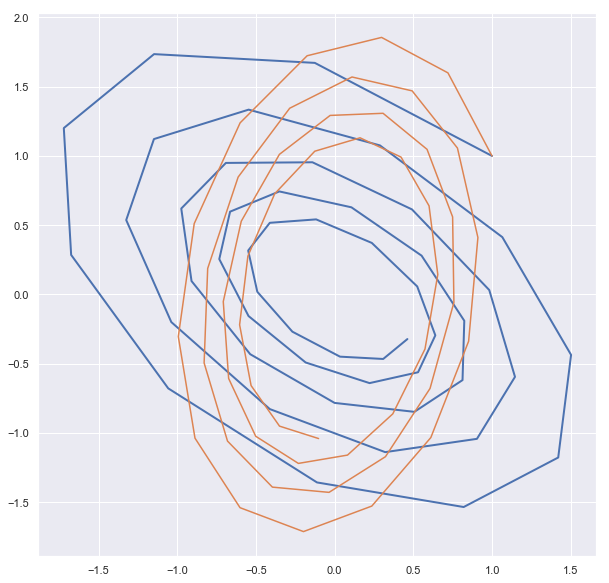

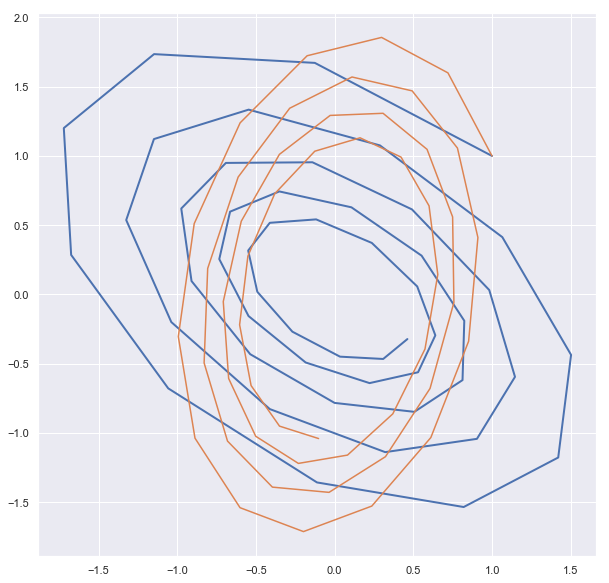

In [590]:
chains, acceptance = lf_mcmc(4, real_data)
samples = []
for chain in chains:
    samples.extend(chains[chain])
a, b, c, d, e = zip(*samples)
plt.plot(acceptance)    

plt.figure(figsize=(15,10))
plt.hist(a[4000::10], 20)
plt.title("Histogram for sampled values of a")
plt.axvline(0.97) # true value of a
plt.show()
plt.figure(figsize=(15,10))
plt.hist(b[4000::10], 20)
plt.title("Histogram for sampled values of b")
plt.axvline(-0.25) # true value of b
plt.show()
plt.figure(figsize=(15,10))
plt.hist(c[4000::10], 20)
plt.title("Histogram for sampled values of c")
plt.axvline(0.8) # true value of c
plt.show()
plt.figure(figsize=(15,10))
plt.hist(d[4000::10], 20)
plt.title("Histogram for sampled values of d")
plt.axvline(0.8) # true value of d
plt.show()

print("The 95% confidence interval for a is", np.percentile(a, [2.5, 97.5]))
print("The 95% confidence interval for b is", np.percentile(b, [2.5, 97.5]))
print("The 95% confidence interval for c is", np.percentile(c, [2.5, 97.5]))
print("The 95% confidence interval for d is", np.percentile(d, [2.5, 97.5]))

import pandas as pd
df = pd.DataFrame(data=np.transpose([a[4000::10],b[4000::10],c[4000::10],d[4000::10]]), columns=['a','b','c','d'])
sns.pairplot(df)

choice = np.random.randint(20000, 40000, 10)
for _ in choice:
    trajectory = [[1, 1]]
    for t in range(50):
        trajectory.append(np.array([[a[_], b[_]], [c[_], d[_]]]).dot(trajectory[-1]))
    x, y = zip(*trajectory)
    plt.figure(figsize=(10,10))
    plt.plot(x, y, lw=2)
    x, y = zip(*real_data)
    plt.plot(x, y)
    plt.show()

The previous plots were performed using ABC-MCMC, which means that it will suffer from the common problems of Metropolis-Hastings, which is that the behavior is similar to that of a random walk. Therefore, to experiment with Hamiltonian methods of ABC, I implement the Hamiltonian ABC algorithm of Meeds, Leenders, and Welling. The Hamiltonian ABC method requires computing a gradient of the likelihood. 

To find the gradient of this log-likelihood, we perform a finite-difference calculation, perturbing each dimension of the parameter $\theta$ and finding the ratio of the change in the log-likelihood and the magnitude of the perturbation. For each parameter dimension, I add and substract a small step to the parameter value, keeping the remaining values constant. Then, I simulate the data using the perturbed parameters (twice). Thus, I use the Gaussian kernel to calculate the distance between data generated by the perturbed parameters and the real data. Subtracting the distance values in the addition and subtraction case, dividing by the step size leads to the partial derivative of the distance metric with respect to that parameter. Repeating this for all 4 parameters gives me the gradient of the log likelihood. To find the gradient of the posterior, I add the gradient of the log likelihood with the gradient of the log prior.

In [583]:
# No sufficient statistics used
from scipy import stats

def lf_hmc_mcmc(dim, real_data, step_size = 0.1, max_t = 400, prior_hyperparams = [0, 0, 0, 0]):
    acceptance = 0
    acceptance_cum = [0]
    chains = {"chain1": [], "chain2": [], "chain3": [], "chain4": []}
    for chain in chains:
        # initial data generation
        a, b, c, d = stats.multivariate_normal.rvs(mean=[0,0,0,0], cov = np.eye(dim))
        trajectory = [[1, 1]]
        for _ in range(50):
            trajectory.append(np.array([[a, b], [c, d]]).dot(trajectory[-1]))
        # distance kernel
        gaussian_dist = [(stats.multivariate_normal.pdf(trajectory[i], real_data[i], np.eye(2))) for i in range(len(trajectory) - 10, len(trajectory))]
        gaussian_dist = np.product(gaussian_dist)
        samples = [(a, b, c, d, gaussian_dist)]

        for _ in range(1, max_t):
            eps = step_size
            
            # propose new parameter values
            a_, b_, c_, d_, gaussian_dist_ = samples[-1] # current values
            a, b, c, d = proposal_function(a_, b_, c_, d_, eps)

            # generate new data
            trajectory = [[1, 1]]
            for _ in range(50):
                trajectory.append(np.array([[a, b], [c, d]]).dot(trajectory[-1]))

            # distance kernel
            gaussian_dist = [(stats.multivariate_normal.pdf(trajectory[i], real_data[i], eps*np.eye(2))) for i in range(len(trajectory) - 10, len(trajectory))]
            gaussian_dist = np.product(gaussian_dist)
            
            numerator = gaussian_dist * stats.multivariate_normal.pdf(prior_hyperparams, [a, b, c, d], np.eye(dim))  
            denom = gaussian_dist_ * stats.multivariate_normal.pdf(prior_hyperparams, [a_, b_, c_, d_], np.eye(dim)) + 1e-30

            # accept or reject state
            if np.random.random() < min(1, numerator/denom):
                acceptance += 1
                samples.append([a, b, c, d, gaussian_dist])
            else:
                samples.append([a_, b_, c_, d_, gaussian_dist_])
            acceptance_cum.append(acceptance)
        chains[chain] = samples
        
    return chains, acceptance_cum


def proposal_function(a_, b_, c_, d_, eps, step = 1):
    momenta = np.random.normal([0, 0, 0, 0], 0.5)
    grad = gradient(a_, b_, c_, d_, eps)
    momenta = momenta - step * grad / 2
    theta = np.array([a_, b_, c_, d_])
    theta += step * momenta
    return theta
    
def gradient(a, b, c, d, eps, step = 0.01, real_data = real_data):
    trajectory = [[1, 1]]
    for _ in range(50):
        trajectory.append(np.array([[a+step, b], [c, d]]).dot(trajectory[-1]))
    # distance kernel
    gaussian_dist_plus = [(stats.multivariate_normal.pdf(trajectory[i], real_data[i], eps*np.eye(2))) for i in range(len(trajectory) - 10, len(trajectory))]
    gaussian_dist_plus = np.product(gaussian_dist_plus)
    trajectory = [[1, 1]]
    for _ in range(50):
        trajectory.append(np.array([[a-step, b], [c, d]]).dot(trajectory[-1]))
    # distance kernel
    gaussian_dist_minus = [(stats.multivariate_normal.pdf(trajectory[i], real_data[i], eps*np.eye(2))) for i in range(len(trajectory) - 10, len(trajectory))]
    gaussian_dist_minus = np.product(gaussian_dist_minus)
    da = (gaussian_dist_plus - gaussian_dist_minus) / 2 / step
    
    trajectory = [[1, 1]]
    for _ in range(50):
        trajectory.append(np.array([[a+step, b], [c, d]]).dot(trajectory[-1]))
    # distance kernel
    gaussian_dist_plus = [(stats.multivariate_normal.pdf(trajectory[i], real_data[i], eps*np.eye(2))) for i in range(len(trajectory) - 10, len(trajectory))]
    gaussian_dist_plus = np.product(gaussian_dist_plus)
    trajectory = [[1, 1]]
    for _ in range(50):
        trajectory.append(np.array([[a-step, b], [c, d]]).dot(trajectory[-1]))
    # distance kernel
    gaussian_dist_minus = [(stats.multivariate_normal.pdf(trajectory[i], real_data[i], eps*np.eye(2))) for i in range(len(trajectory) - 10, len(trajectory))]
    gaussian_dist_minus = np.product(gaussian_dist_minus)
    db = (gaussian_dist_plus - gaussian_dist_minus) / 2 / step
    
    trajectory = [[1, 1]]
    for _ in range(50):
        trajectory.append(np.array([[a+step, b], [c, d]]).dot(trajectory[-1]))
    # distance kernel
    gaussian_dist_plus = [(stats.multivariate_normal.pdf(trajectory[i], real_data[i], eps*np.eye(2))) for i in range(len(trajectory) - 10, len(trajectory))]
    gaussian_dist_plus = np.product(gaussian_dist_plus)
    trajectory = [[1, 1]]
    for _ in range(50):
        trajectory.append(np.array([[a-step, b], [c, d]]).dot(trajectory[-1]))
    # distance kernel
    gaussian_dist_minus = [(stats.multivariate_normal.pdf(trajectory[i], real_data[i], eps*np.eye(2))) for i in range(len(trajectory) - 10, len(trajectory))]
    gaussian_dist_minus = np.product(gaussian_dist_minus)
    dc = (gaussian_dist_plus - gaussian_dist_minus) / 2 / step
    
    trajectory = [[1, 1]]
    for _ in range(50):
        trajectory.append(np.array([[a+step, b], [c, d]]).dot(trajectory[-1]))
    # distance kernel
    gaussian_dist_plus = [(stats.multivariate_normal.pdf(trajectory[i], real_data[i], eps*np.eye(2))) for i in range(len(trajectory) - 10, len(trajectory))]
    gaussian_dist_plus = np.product(gaussian_dist_plus)
    trajectory = [[1, 1]]
    for _ in range(50):
        trajectory.append(np.array([[a-step, b], [c, d]]).dot(trajectory[-1]))
    # distance kernel
    gaussian_dist_minus = [(stats.multivariate_normal.pdf(trajectory[i], real_data[i], eps*np.eye(2))) for i in range(len(trajectory) - 10, len(trajectory))]
    gaussian_dist_minus = np.product(gaussian_dist_minus)
    dd = (gaussian_dist_plus - gaussian_dist_minus) / 2 / step
    
    likelihood_gradient = np.array([da, db, dc, dd])
    posterior_gradient = likelihood_gradient + np.array([a, b, c, d])
    
    return posterior_gradient
        
    
    



Note the acceptance cumulative distribution. We can see here the advantage of Hamiltonian ABC over the Metropolis-Hastings ABC-MCMC. The acceptance probability here is more than 10%, which is more than quadruple the acceptance probability of the ABC-MCMC distribution (compare with the acceptance cumulative distribution plot for ABC-MCMC). However, we can see that the posterior distribution misses the actual value of the data. This could be bias introduced by the summary statistics not being good enough to convey all the information about the data. Furthermore, if I had more time, I will monitor the convergence and mixing of the chains using statistics such as Rhat. Since the distribution is multimodal, I strongly suspect that my implementation could have been stuck in one mode and could not explore the rest of the posterior.  Furthermore, the likelihood trajectories generated by ABC-MCMC using the same small step size look much better, which could be one clue that the posterior created by ABC-MCMC is less subject to bias, although I could have been lucky with the draws I made. The sample trajectories look much more similar to the error-augmented sampler, which could be a clue that both implementations could benefit from more careful examination to reduce bias. 

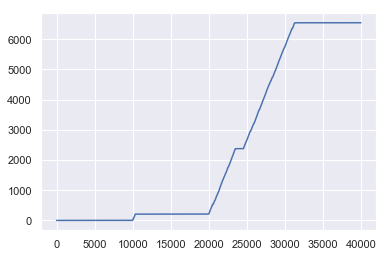

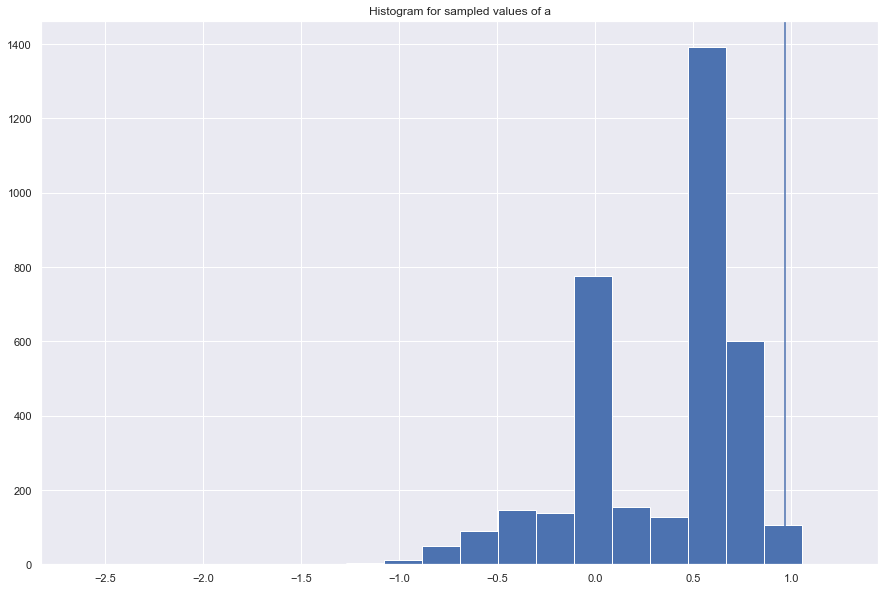

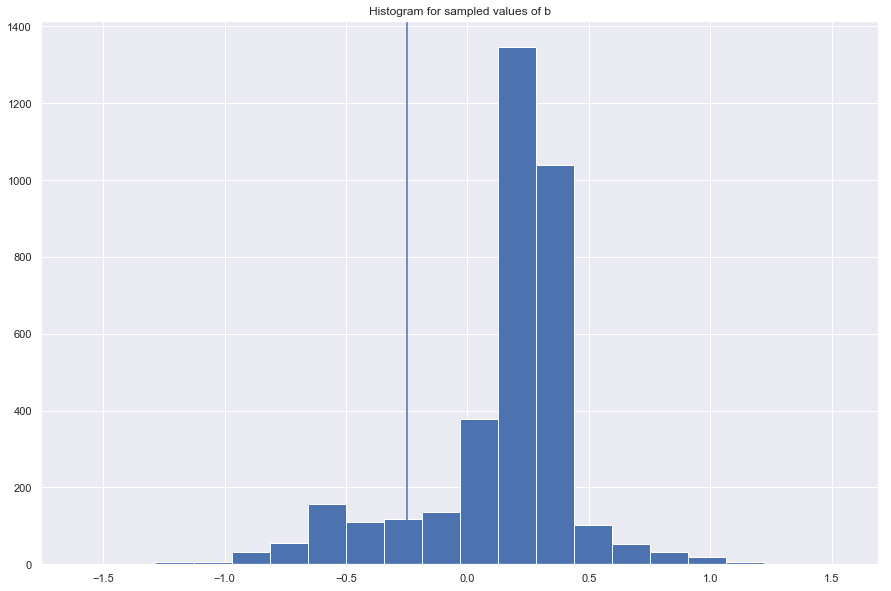

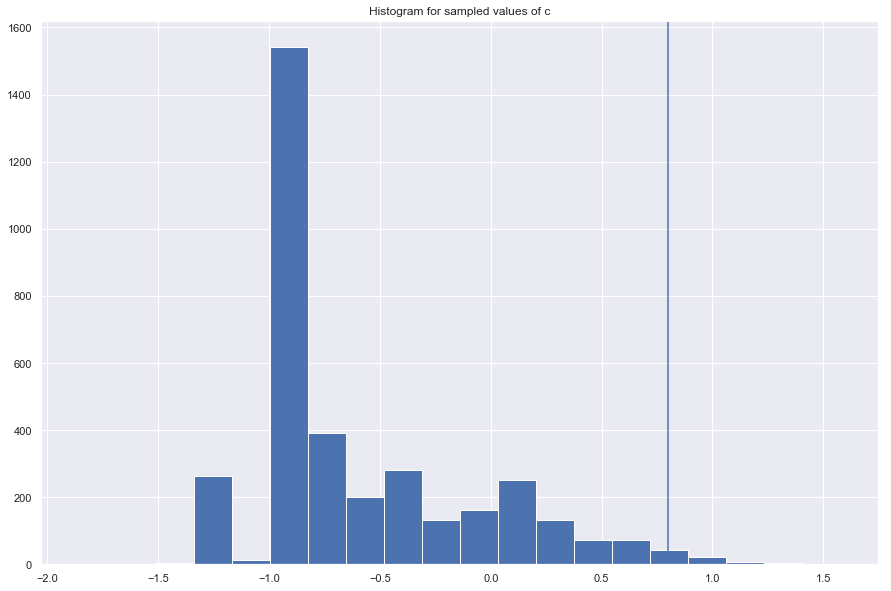

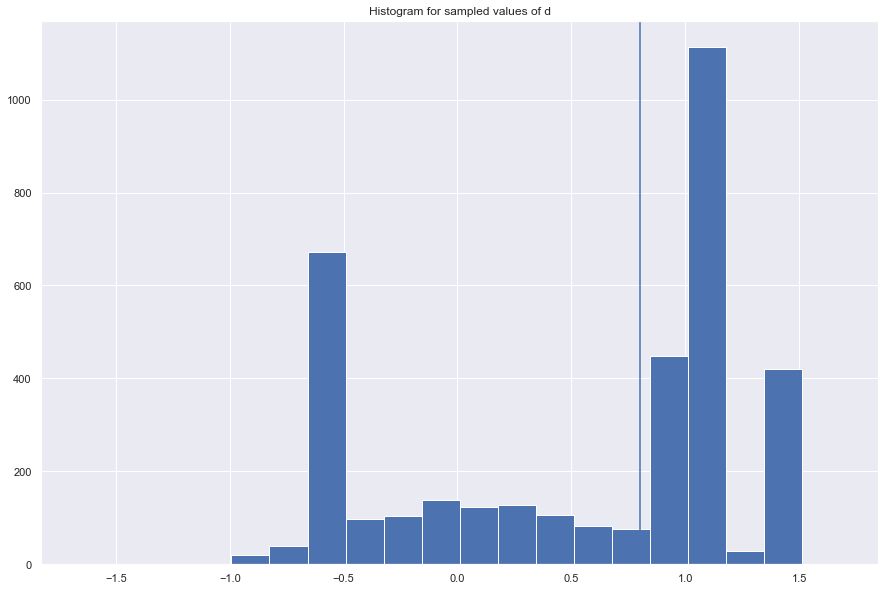

In [585]:
chains, acceptance = lf_hmc_mcmc(4, real_data, max_t=10000)
plt.plot(acceptance)
samples = []
for chain in chains:
    samples.extend(chains[chain])
    
a, b, c, d, e = zip(*samples)

plt.figure(figsize=(15,10))
plt.hist(a[4000::10], 20)
plt.title("Histogram for sampled values of a")
plt.axvline(0.97) # true value of a
plt.show()
plt.figure(figsize=(15,10))
plt.hist(b[4000::10], 20)
plt.title("Histogram for sampled values of b")
plt.axvline(-0.25) # true value of b
plt.show()
plt.figure(figsize=(15,10))
plt.hist(c[4000::10], 20)
plt.title("Histogram for sampled values of c")
plt.axvline(0.8) # true value of c
plt.show()
plt.figure(figsize=(15,10))
plt.hist(d[4000::10], 20)
plt.title("Histogram for sampled values of d")
plt.axvline(0.8) # true value of d
plt.show()

The 95% confidence interval for a is [-0.61364972  0.93886713]
The 95% confidence interval for b is [-0.65040388  0.61302285]
The 95% confidence interval for c is [-1.19060112  0.68374076]
The 95% confidence interval for d is [-0.55167532  1.39755653]


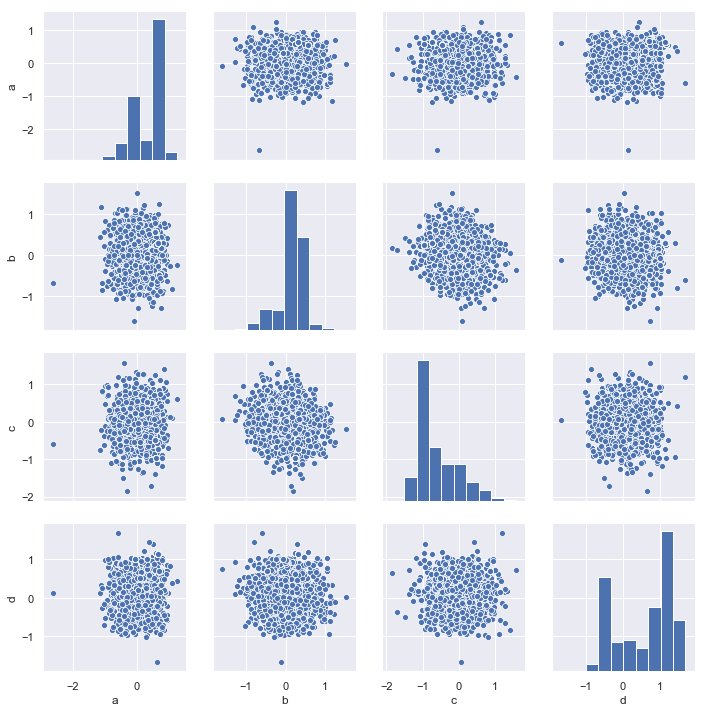

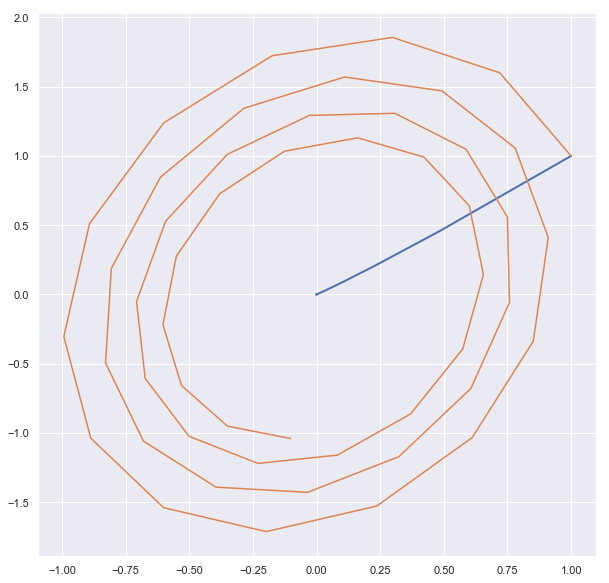

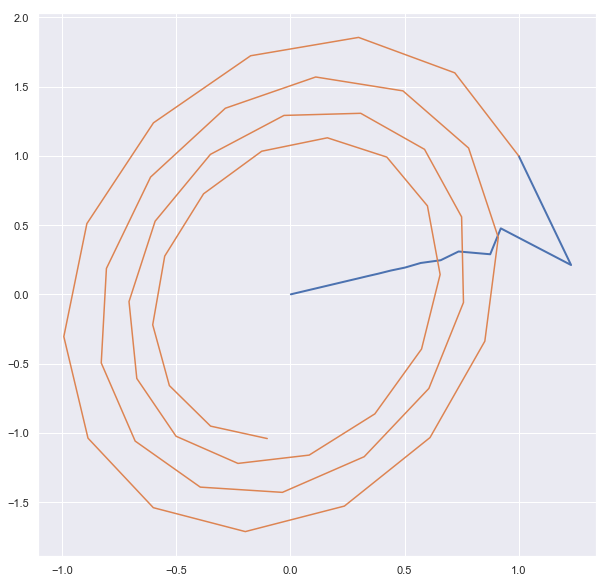

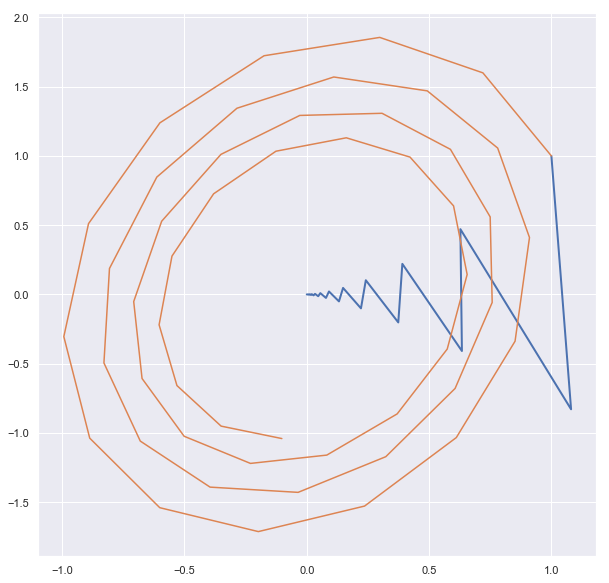

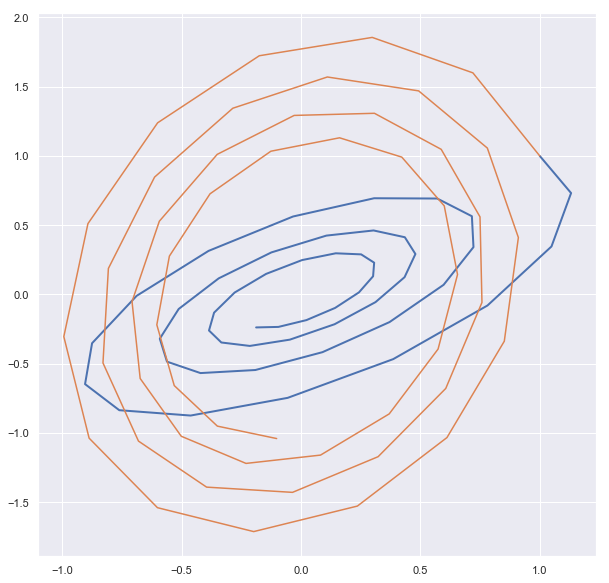

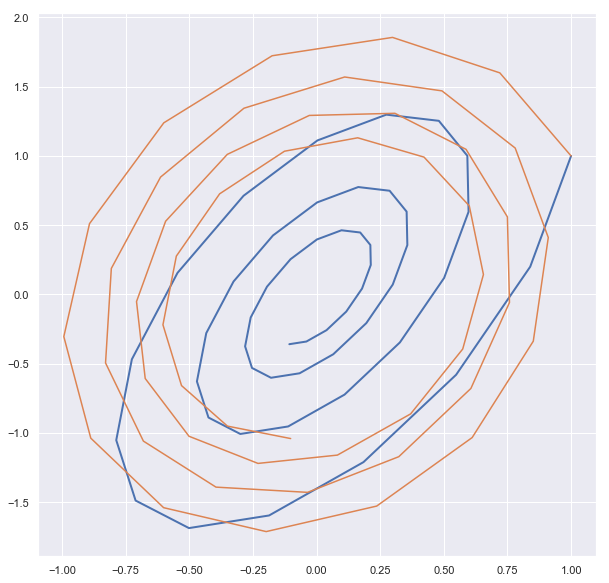

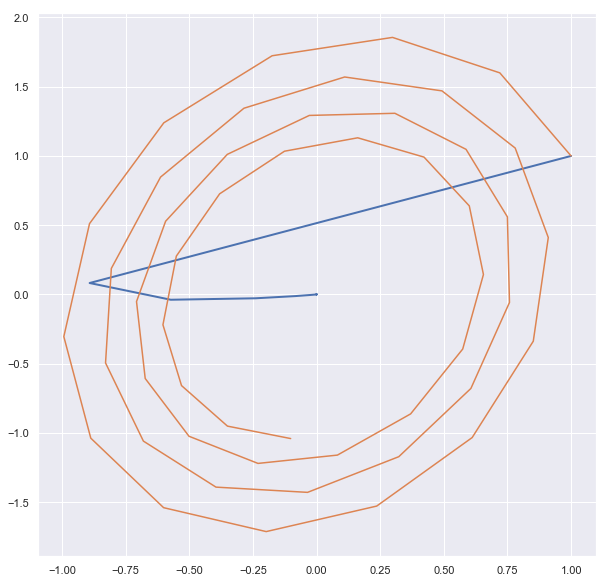

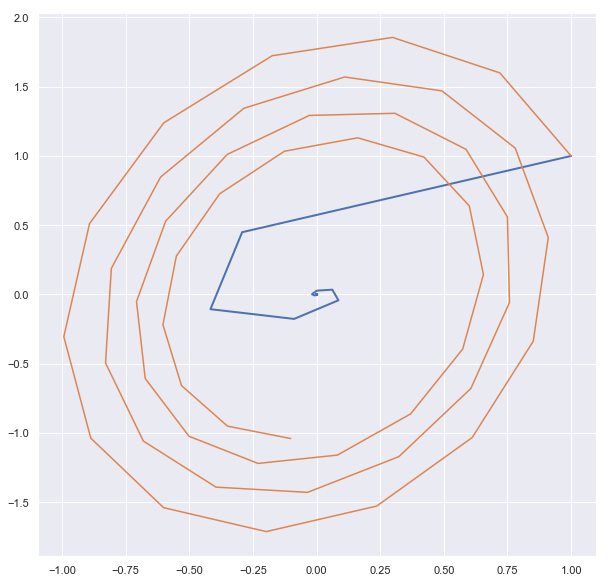

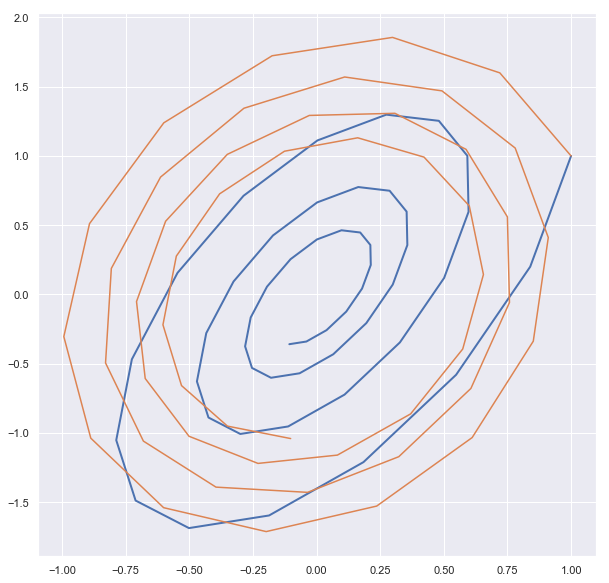

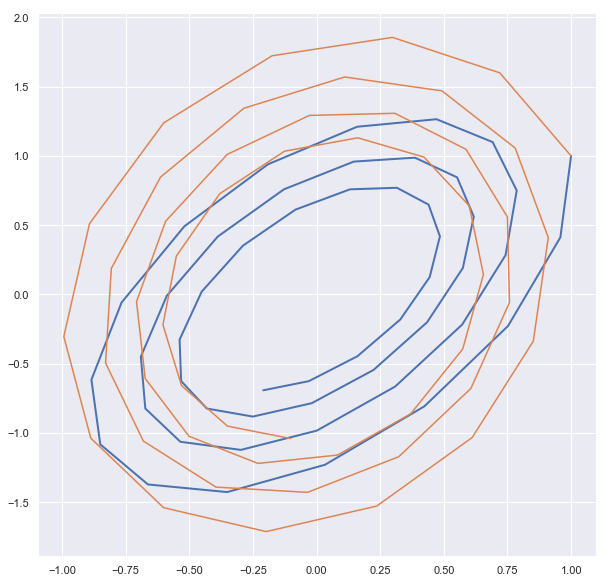

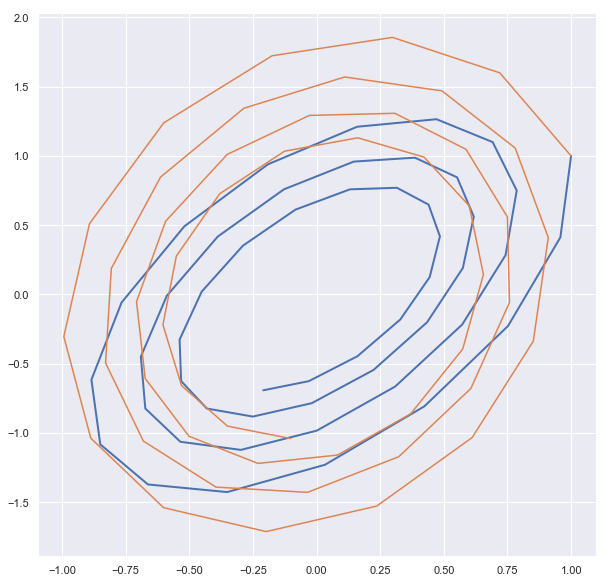

In [586]:
print("The 95% confidence interval for a is", np.percentile(a, [2.5, 97.5]))
print("The 95% confidence interval for b is", np.percentile(b, [2.5, 97.5]))
print("The 95% confidence interval for c is", np.percentile(c, [2.5, 97.5]))
print("The 95% confidence interval for d is", np.percentile(d, [2.5, 97.5]))

import pandas as pd
df = pd.DataFrame(data=np.transpose([a[4000::10],b[4000::10],c[4000::10],d[4000::10]]), columns=['a','b','c','d'])
sns.pairplot(df)

choice = np.random.randint(20000, 40000, 10)
for _ in choice:
    trajectory = [[1, 1]]
    for t in range(50):
        trajectory.append(np.array([[a[_], b[_]], [c[_], d[_]]]).dot(trajectory[-1]))
    x, y = zip(*trajectory)
    plt.figure(figsize=(10,10))
    plt.plot(x, y, lw=2)
    x, y = zip(*real_data)
    plt.plot(x, y)
    plt.show()

# References

1. Meeds, E., Leenders, R. and Welling, M. (2018). Hamiltonian ABC. [online] Arxiv.org. Available at: https://arxiv.org/abs/1503.01916 [Accessed 21 Oct. 2018].
2. Picchini, U. (2018). State space models and intractable likelihoods. [online] Umberto Picchini's research blog. Available at: https://umbertopicchini.wordpress.com/2016/10/10/state-space-models-intractable-likelihoods/ [Accessed 21 Oct. 2018].